In [1]:
import numpy as np
from scipy.stats import pearsonr, spearmanr, zscore
import matplotlib.pyplot as plt
from tqdm import tqdm
import sys


from main import *
from useful_functions import *
from genes import *
from stats import *

plt.rcParams['font.size'] = 18

/home/anleg84/anaconda3/envs/calimba/lib/python3.9/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


In [2]:
excluded = np.load('Results/excluded_regions.npy') # Regions excluded from analysis
excluded_bilateral = np.concatenate([np.array(excluded), np.array(excluded) + 70])

FC = np.load('Genes/FC_matrix.npy')
triangle = np.triu_indices(FC.shape[0], 1)

region_centroids = np.delete(np.load('Genes/region_centroids.npy'), excluded_bilateral, axis=0)
region_centroids[:, 1] = 974 - region_centroids[:, 1]
centroids = region_centroids
atlas_XY = np.load('Genes/atlas_XYprojection.npy')
atlas_YZ = np.load('Genes/atlas_YZprojection.npy')

In [3]:
delete = delete_rows_and_columns

In [4]:
atlas_path = '/home/anleg84/Documents/Atlas/Mapzebrain/'
atlas = MapzebrainAtlas(atlas_path)
distances = delete(atlas.computeDistanceBetweenRegions(), excluded)

Todolist:

- Rouler l'optimisation beaucoup plus de fois
- Générer au moins 1000 shuffled gene datasets
- Vérifer si les meilleures combinaisons du null dataset correspondent en fait à des gènes mal shuffled du dataset original

# Compiling

In [5]:
path = '/media/anleg84/Backup Plus/CERVO/Atlas/Mapzebrain/Gene expression/'
files = identify_files(path, ['.tif'])

compile_genes = False

if compile_genes:
    
    for file in tqdm(files, file=sys.stdout):
        gene_name = file.split('.tif')[0].split('T_AVG_')[1]
        # print(gene_name)
        stack = np.flip(load_stack(path + file), axis=0)
        # Background patch selected within upper imaging volume, not too close to skin to avoid fluorescence artifacts,
        # and not to far to avoid registration volume overlap artifacts
        background_intensity = np.mean(stack[359 - 320, 175-25:175+25, 284-25:284+25]) + 1
        
        regional_intensities = []
        for i in range(len(atlas.names)):
            regional_intensities.append(np.mean(stack[atlas.getRegionMask(i) == 255]) / background_intensity)
        regional_intensities = np.array(regional_intensities)
        np.save(path + 'expression_{}.npy'.format(gene_name), regional_intensities)

    files = identify_files(path, ['.npy'])
    expression = []
    for file in files:
        exp = np.load(path + file)
        expression.append(exp)

    np.save('Results/gene_expression.npy', expression)

# Gene expression

In [6]:
expression = np.delete(np.load('Results/gene_expression.npy'), excluded, axis=1)
expression = zscore(expression, axis=0)

names = np.load('Genes/gene_names.npy')

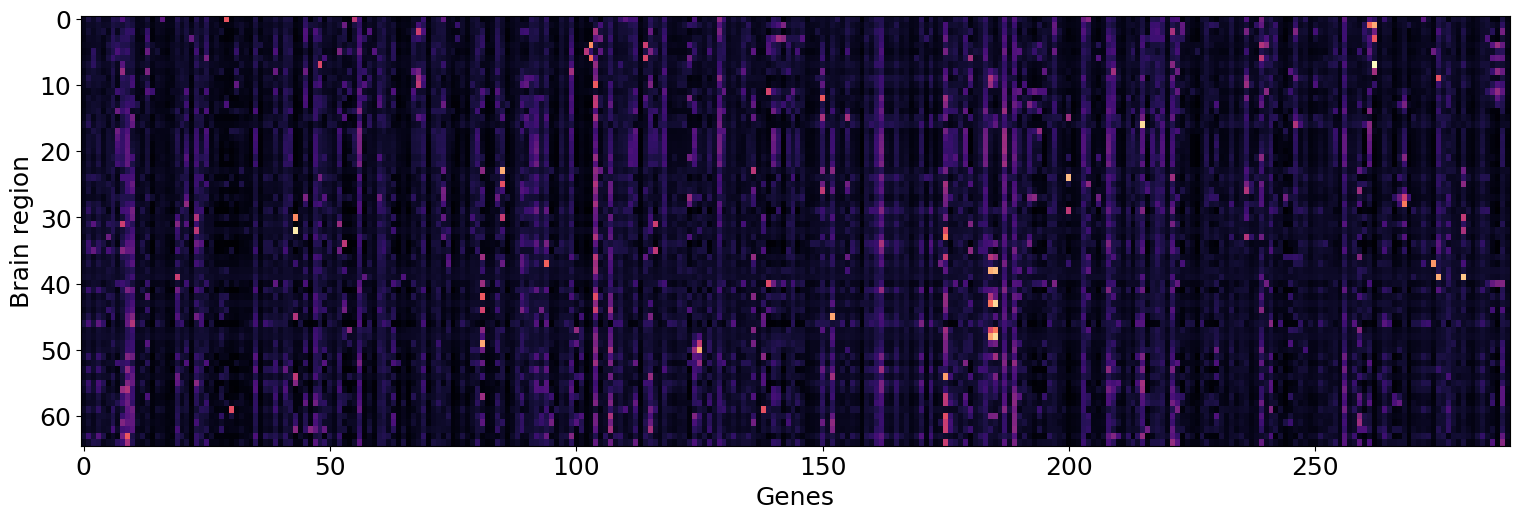

In [7]:
plt.figure(figsize=(15, 5))
plt.imshow(expression.T, aspect='auto', cmap='magma')
plt.ylabel('Brain region')
plt.xlabel('Genes')
plt.tight_layout(pad=0)

In [8]:
if not os.path.isdir(os.getcwd() + '/Results/GeneExpression/'):
    os.mkdir(os.getcwd() + '/Results/GeneExpression/')

shuffle_genes = False
if shuffle_genes:
    i_start = len(identify_files('Results/GeneExpression/', ['brainsmash', '.npy']))
    for i in tqdm(range(750), file=sys.stdout):
        expression_shuffled = shuffle_expression(expression, distances)
        np.save('Results/GeneExpression/expression_shuffled_brainsmash_{}.npy'.format(i_start + i + 1), expression_shuffled)

files = identify_files('Results/GeneExpression/', ['expression', 'brainsmash', '.npy'])
expressions_shuffled = []
for file in files:
    expression_shuffled = np.load('Results/GeneExpression/' + file)
    expressions_shuffled.append(expression_shuffled)

In [9]:
np.save('ComputeCanada/gene_expression_shuffled.npy', np.stack(expressions_shuffled))

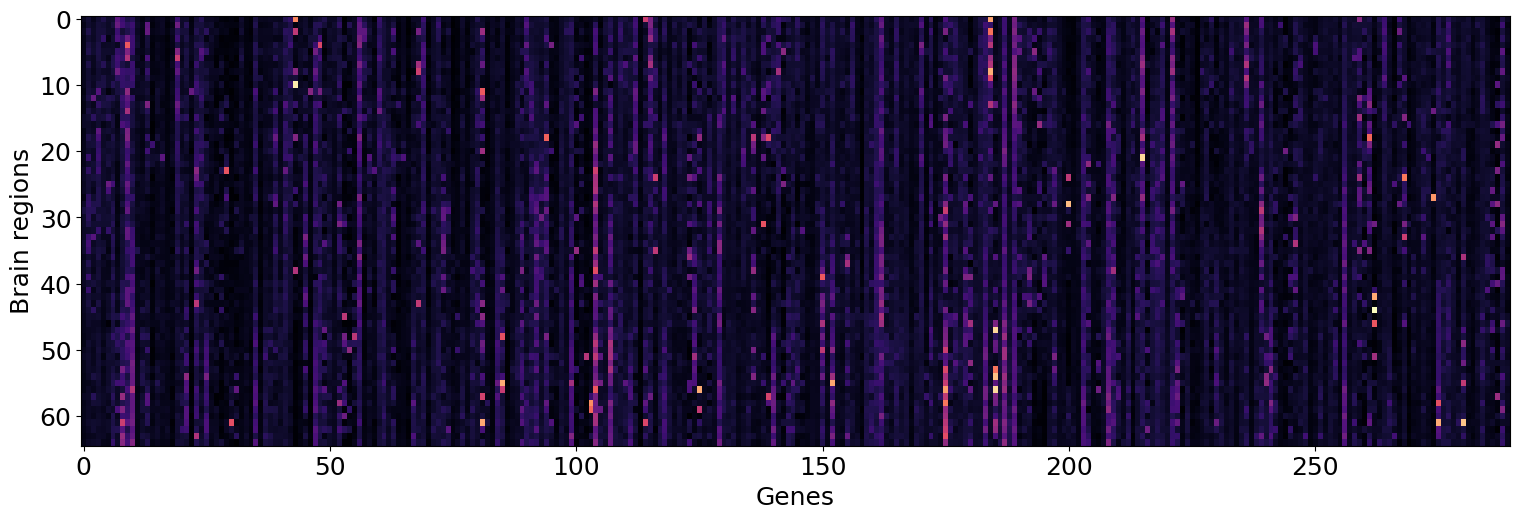

In [10]:
plt.figure(figsize=(15, 5))
plt.imshow(expressions_shuffled[int(np.random.uniform(0, len(expressions_shuffled)))].T, aspect='auto', cmap='magma')
plt.ylabel('Brain regions')
plt.xlabel('Genes')
plt.tight_layout(pad=0)

# Baseline coexpression (across all genes)

In [11]:
coexpression = np.corrcoef(expression.T)

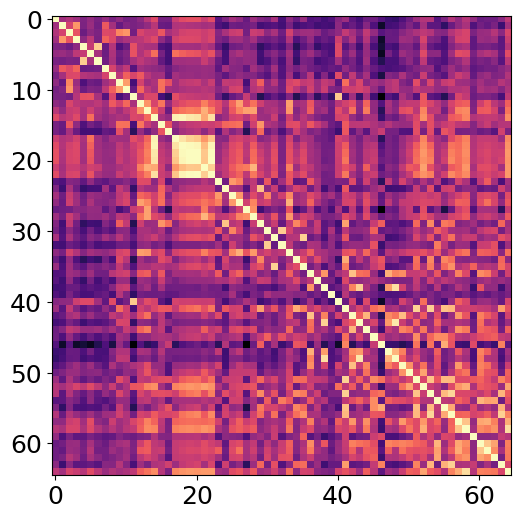

In [12]:
plt.figure(figsize=(5, 5))
plt.imshow(coexpression, cmap='magma')
plt.tight_layout(pad=0)

In [13]:
numba_nmi(coexpression[triangle], FC[triangle])

0.05063828789648737

In [14]:
np.save('Results/figure7_coexpression_all.npy', coexpression)

#### Null model

In [15]:
nmi_coexpression_shuffled = []
for e in expressions_shuffled:
    coexpression_shuffled = np.corrcoef(e.T)
    nmi = numba_nmi(coexpression_shuffled[triangle], FC[triangle])
    nmi_coexpression_shuffled.append(nmi)

In [16]:
np.percentile(nmi_coexpression_shuffled, 95)

0.0542588807404563

In [17]:
np.save('Results/figure7_nmi_distribution_all_null.npy', nmi_coexpression_shuffled)

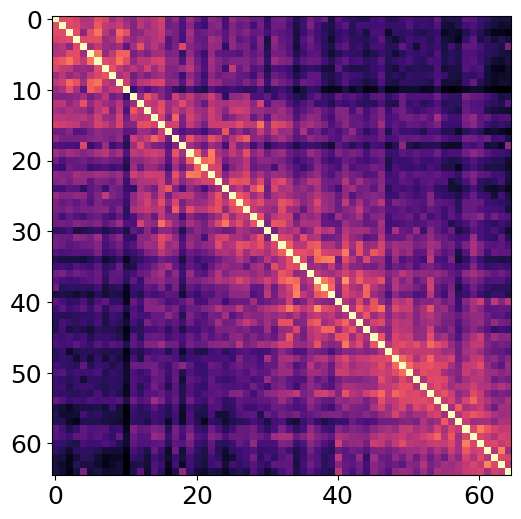

In [18]:
plt.figure(figsize=(5, 5))
plt.imshow(coexpression_shuffled, cmap='magma')
plt.tight_layout(pad=0)

In [19]:
np.save('Results/figure7_coexpression_all_null.npy', coexpression_shuffled)

# Simulated annealing: How many genes?

#### Sweeping number of genes for predicting FC

In [27]:
N_selected = np.arange(2, 30)

scores_per_N = []
scores_per_N_null = []

for N in tqdm(N_selected, file=sys.stdout):

    # Empirical genes
    selected_genes = []
    for _ in range(1):
        selected_genes.append(simulated_annealing(expression, FC, method='nmi', N_selected=N, iterations=20000))
    scores = []
    for s in selected_genes:
        scores.append(objective_function(expression[s], FC, method='nmi'))
    scores_per_N.append(scores)

    # Shuffled genes
    selected_genes_null, scores = [], []
    for _ in range(1):
        random_id = int(np.random.uniform(0, len(expressions_shuffled)))
        expression_shuffled = expressions_shuffled[random_id]
        s = simulated_annealing(expression_shuffled, FC, method='nmi', N_selected=N, iterations=20000)
        selected_genes_null.append(s)
        scores.append(objective_function(expression_shuffled[s], FC, method='nmi'))
    scores_per_N_null.append(scores)

100%|███████████████████████████████████████████| 28/28 [01:22<00:00,  2.94s/it]


np.save('Results/figure7_scores_per_N_nmi.npy', np.stack(scores_per_N))
np.save('Results/figure7_scores_per_N_nmi_null.npy', np.stack(scores_per_N_null))

#### Analyzing results

In [52]:
scores_per_N_1 = np.load('ComputeCanada/figure7_scores_per_N_nmi_2-14.npy')
scores_per_N_2 = np.load('ComputeCanada/figure7_scores_per_N_nmi_15.npy')
scores_per_N_3 = np.load('ComputeCanada/figure7_scores_per_N_nmi_16-29.npy')
scores_per_N = np.concatenate([scores_per_N_1, scores_per_N_2, scores_per_N_3], axis=0)

scores_per_N_1_null = np.load('ComputeCanada/figure7_scores_per_N_nmi_null_2-14.npy')
scores_per_N_2_null = np.load('ComputeCanada/figure7_scores_per_N_nmi_null_15.npy')
scores_per_N_3_null = np.load('ComputeCanada/figure7_scores_per_N_nmi_null_16-29.npy')
scores_per_N_null = np.concatenate([scores_per_N_1_null, scores_per_N_2_null, scores_per_N_3_null], axis=0)

In [61]:
N_selected = np.arange(2, 30)

#scores_per_N = np.load('Results/figure7_scores_per_N_nmi.npy')
#scores_per_N_null = np.load('Results/figure7_scores_per_N_nmi_null.npy')

In [75]:
scores = np.mean(scores_per_N, axis=1)
scores_null = np.mean(scores_per_N_null, axis=1)
scores_perc = np.percentile(scores_per_N, 95, axis=1)
scores_null_perc = np.percentile(scores_per_N_null, 95, axis=1)

In [82]:
elbow, _ = find_elbow_point(N_selected[1:], scores[1:])
print(elbow)

9


In [157]:
N_selected[np.argmax(scores_perc)]

29

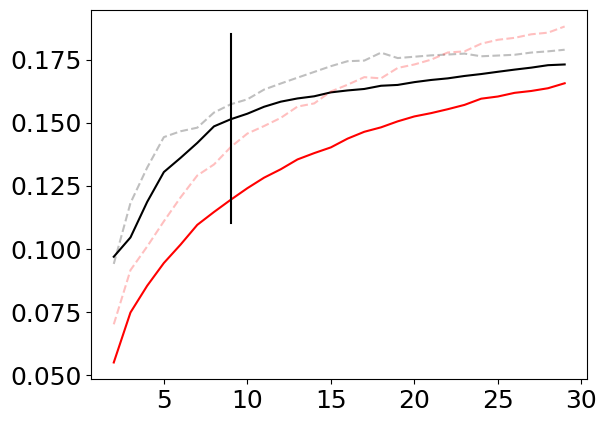

In [159]:
plt.plot(N_selected, scores, color='black')
plt.plot(N_selected, scores_null, color='red')

plt.plot(N_selected, scores_perc, color='black', linestyle='--', alpha=0.25)
plt.plot(N_selected, scores_null_perc, color='red', linestyle='--', alpha=0.25)

plt.plot([elbow, elbow], [0.11, 0.185], color='black')
#plt.xlim([3, 29])

## Simulated annealing to find optimal subsets of genes

In [84]:
N = 9

selected_genes = []
for _ in tqdm(range(1000), file=sys.stdout):
    result = simulated_annealing(expression, FC, method='nmi', N_selected=N, iterations=20000)
    selected_genes.append(result)

100%|███████████████████████████████████████| 1000/1000 [20:05<00:00,  1.21s/it]


In [85]:
selected_genes_null, random_ids_null = [], []
for _ in tqdm(range(1000), file=sys.stdout):
    random_id = int(np.random.uniform(0, len(expressions_shuffled)))
    expression_shuffled = expressions_shuffled[random_id]
    result = simulated_annealing(expression_shuffled, FC, method='nmi', N_selected=N, iterations=20000)
    selected_genes_null.append(result)
    random_ids_null.append(random_id)

100%|███████████████████████████████████████| 1000/1000 [19:40<00:00,  1.18s/it]


In [86]:
np.save('Results/selected_genes9.npy', selected_genes)
np.save('Results/selected_genes_null9.npy', selected_genes_null)
np.save('Results/random_ids_null9.npy', random_ids_null)

# Studying most selected genes

In [123]:
selected_genes = np.load('Results/selected_genes9.npy')
selected_genes_null = np.load('Results/selected_genes_null9.npy')
random_ids_null = np.load('Results/random_ids_null9.npy')

In [124]:
score_empirical, score_null = [], []

for s in selected_genes:
    score_empirical.append(objective_function(expression[s], FC, method='nmi'))

for i, s in enumerate(selected_genes_null):
    triangle = np.triu_indices(FC.shape[0], 1)
    score_null.append(objective_function(expressions_shuffled[random_ids_null[i]][s], FC, method='nmi'))

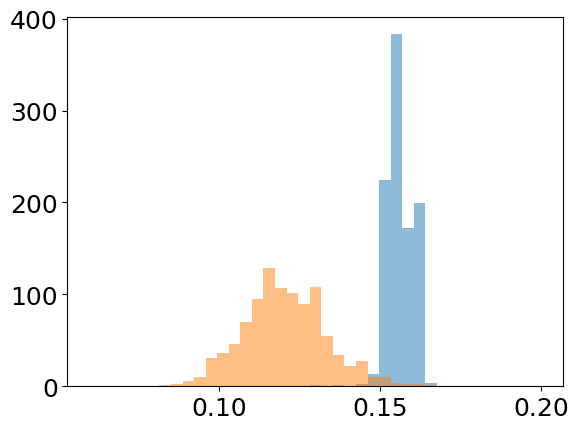

In [125]:
#bins = np.linspace(0.5, 0.7, 30)
bins = np.linspace(0.06, 0.2, 40)

plt.hist(score_empirical, bins=bins, alpha=0.5)
plt.hist(score_null, bins=bins, alpha=0.5)
plt.show()

In [128]:
np.mean(score_empirical) / np.mean(score_null)

1.296726013079675

In [130]:
np.percentile(score_empirical, 95) / np.percentile(score_null, 95)

1.141857587263126

#### Identifying most selected genes

In [90]:
number_of_selections = np.zeros((expression.shape[0]))
number_of_selections_null = np.zeros((expression.shape[0]))

for s in selected_genes:
    number_of_selections[s] += 1

for s in selected_genes_null:
    number_of_selections_null[s] += 1

In [198]:
np.mean(number_of_selections_null) + 3 * np.std(number_of_selections_null)

91.60273712000424

In [199]:
np.max(number_of_selections_null)

103.0

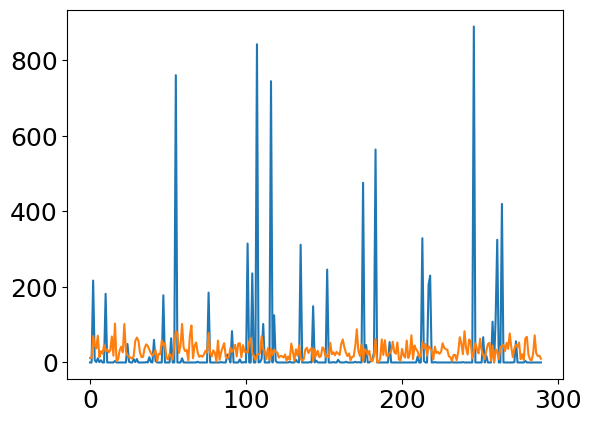

In [91]:
plt.plot(number_of_selections)
plt.plot(number_of_selections_null)

In [131]:
names[np.argmax(number_of_selections)]

'sox1b'

In [132]:
pearsonr(number_of_selections, number_of_selections_null)

(0.0816462839304261, 0.16553408518575655)

In [133]:
np.save('Results/figure7_number_of_selections9.npy', number_of_selections)
np.save('Results/figure7_number_of_selections_null9.npy', number_of_selections_null)

In [160]:
threshold = np.max(number_of_selections_null)

In [161]:
N_above_threshold = np.sum(number_of_selections > threshold)
print(N_above_threshold)

23


In [162]:
significant_genes = np.where(number_of_selections > threshold)[0]

In [163]:
names[significant_genes]

array(['CABZ01073265.1', 'aldocb', 'chrm2a', 'crema', 'eomesa', 'glyt2',
       'grik2', 'hcn1', 'isl2b', 'kif11', 'mef2cb', 'neurog1', 'nkx6.2',
       'nxph1', 'opn7b', 'pth2r', 'pyyb', 'r3hdm2', 'sox1b', 'stc2a',
       'tac1', 'tac3b', 'tbx2b'], dtype='<U16')

In [164]:
np.save('Results/figure7_significant_genes.npy', significant_genes)

# Rendering image

In [167]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 
import contextlib
from scipy.ndimage import distance_transform_edt
from scipy.ndimage import gaussian_filter

@contextlib.contextmanager
def temp_random_state(seed=None):
    state = np.random.get_state()  # Save the current state
    np.random.seed(seed)  # Set the temporary seed
    try:
        yield  # Perform your operations within this block
    finally:
        np.random.set_state(state)  # Restore the original state

def sigmoid_contrast(image, gain=10, cutoff=0.5):
    return 1 / (1 + np.exp(gain * (cutoff - image)))

def merge(images, colors, gain=10, cutoff=0.5, contrast=False):
   
    if len(images) != len(colors):
        raise ValueError("Each image must have a corresponding color.")

    height, width = images[0].shape
    rgb_image = np.zeros((height, width, 3), dtype=np.float32)

    for img, color in zip(images, colors):
        for c in range(3):  # Iterate over RGB channels
            normalized_img = img / np.max(img) if np.max(img) > 0 else img
            rgb_image[:, :, c] += normalized_img * color[c]

    rgb_image /= np.max(rgb_image)

    for c in range(3):
        if contrast:
            rgb_image[:, :, c] = sigmoid_contrast(rgb_image[:, :, c], gain=gain, cutoff=cutoff)
        else:
            rgb_image[:, :, c] = rgb_image[:, :, c]
    return rgb_image

def merge_with_pixelwise_color_contrast(images, colors):
    height, width = images[0].shape
    rgb_image = np.zeros((height, width, 3), dtype=np.float32)

    for img, color in zip(images, colors):
        normalized_img = img / np.max(img) if np.max(img) > 0 else img
        weights = normalized_img / np.sum([img / np.max(img) if np.max(img) > 0 else img for img in images], axis=0)
        for c in range(3):
            rgb_image[:, :, c] += weights * normalized_img * color[c]

    rgb_image /= np.max(rgb_image)

    rgb_image_8bit = np.uint8(rgb_image * 255)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    for c in range(3):
        rgb_image_8bit[:, :, c] = clahe.apply(rgb_image_8bit[:, :, c])

    rgb_image = rgb_image_8bit.astype(np.float32) / 255

    return rgb_image


In [180]:
optimized_names = names[np.sort(significant_genes)]

In [181]:
optimized_names = list(optimized_names)

In [182]:
optimized_names.remove('stc2a')

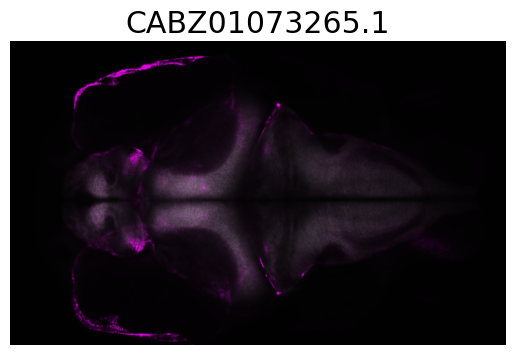

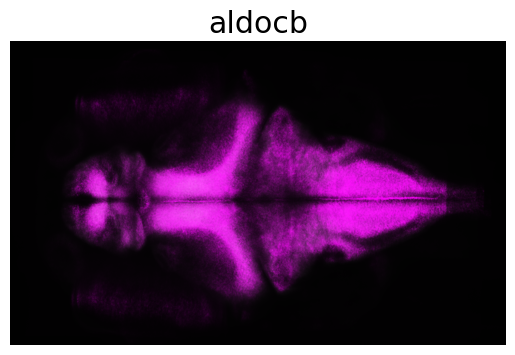

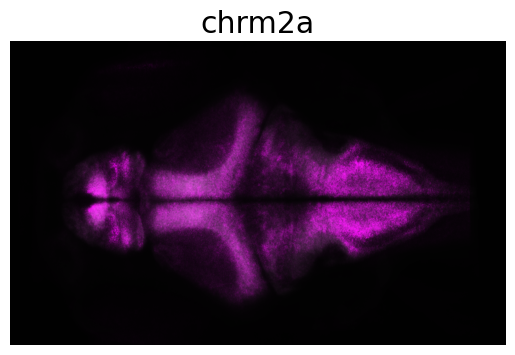

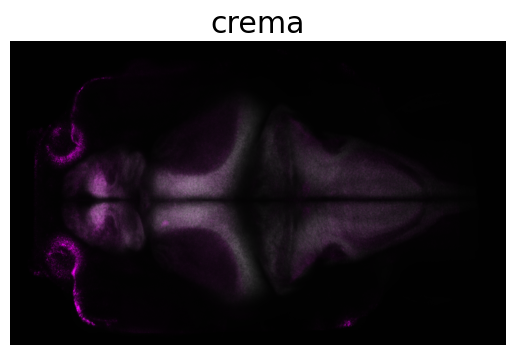

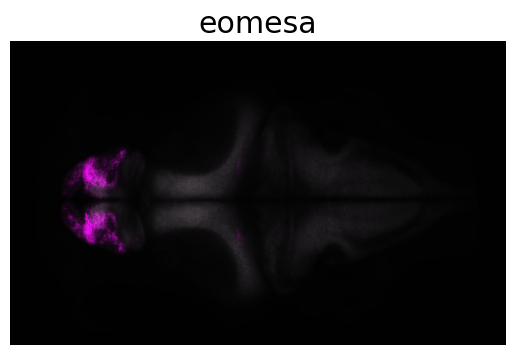

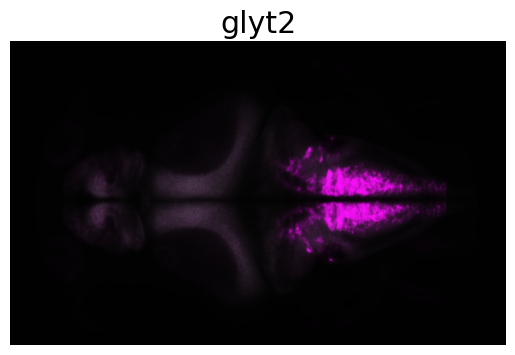

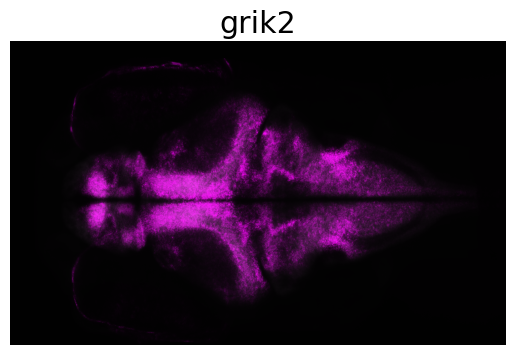

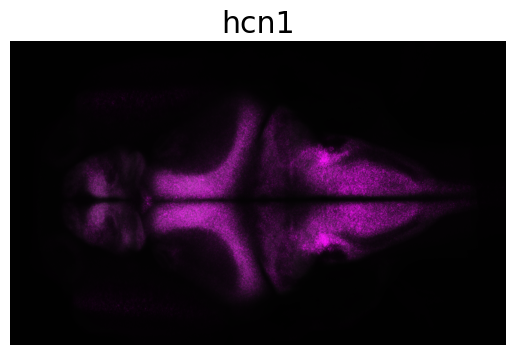

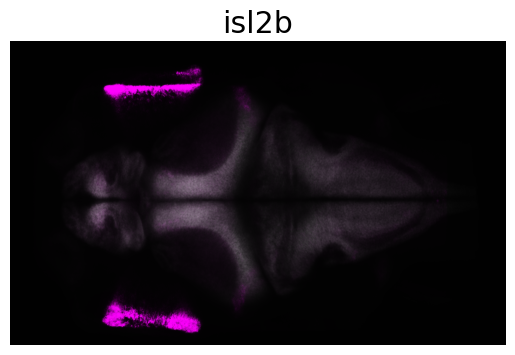

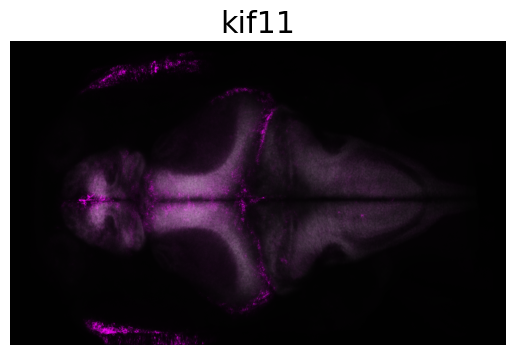

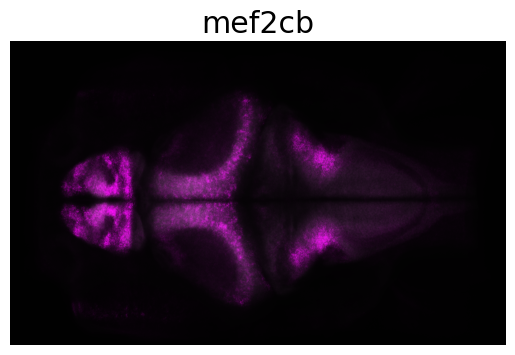

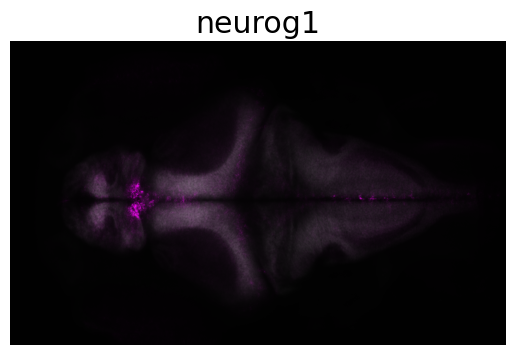

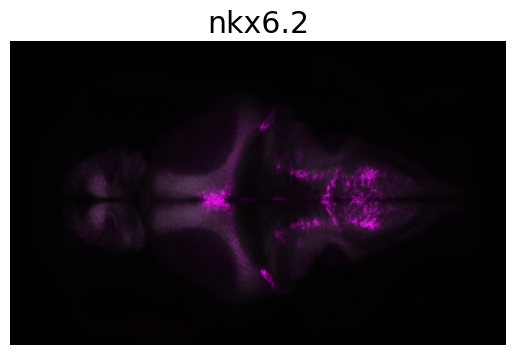

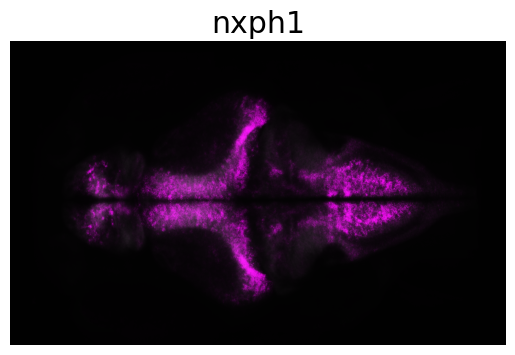

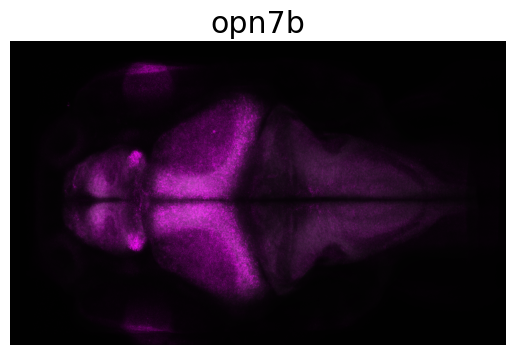

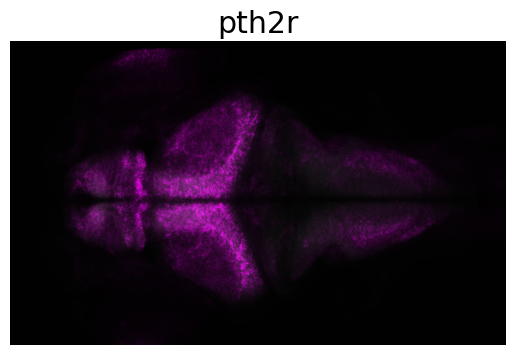

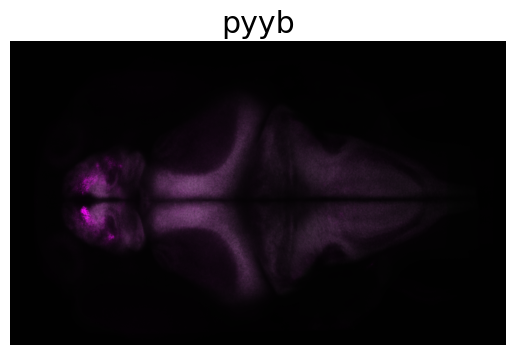

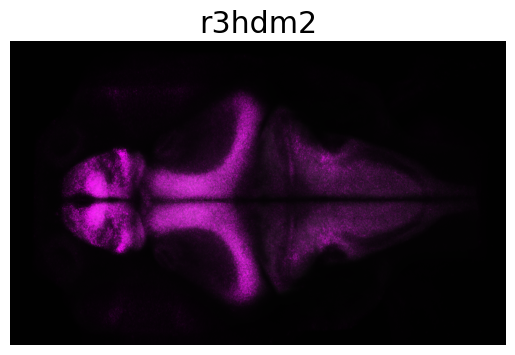

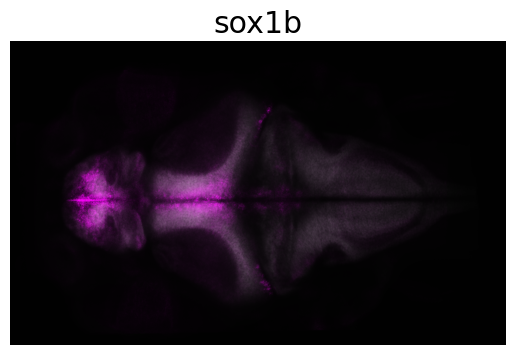

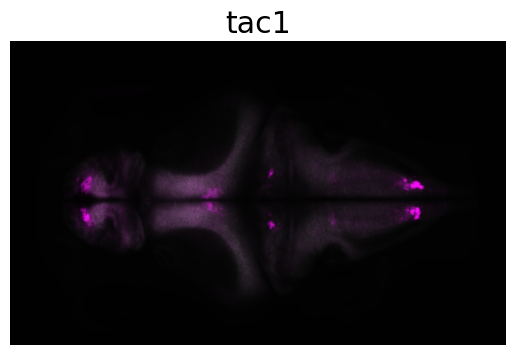

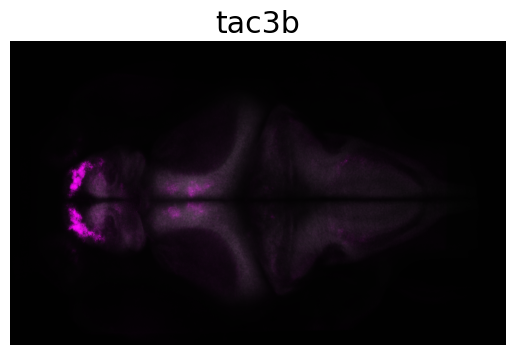

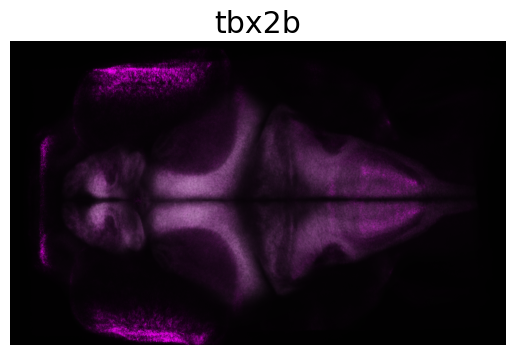

In [183]:
path = '/media/anleg84/Backup Plus/CERVO/Atlas/Mapzebrain/Gene expression/'
files = identify_files(path, ['.tif'])

projections_top, projections_side = [], []
for name in optimized_names:
    for file in files:
        if name == file.strip('.tif').strip('T_AVG_'):
            stack = np.flip(load_stack(path + file), axis=0)
            projection_top = np.percentile(stack[::2, :, :], 90, axis=0)
            #projection_top = np.mean(stack, axis=0)
            projections_top.append(projection_top + 1)
            projection_side = np.percentile(stack[:, :, ::2], 90, axis=2)
            #projection_side = np.mean(stack, axis=2)
            projections_side.append(projection_side + 1)

            colors = [[0.5, 0.5, 0.5], [1, 0, 1]]
            im1 = merge([atlas.XYprojection, projection_top], colors, contrast=True)
            plt.imshow(np.rot90(im1))
            plt.axis('off')
            plt.title(name)
            plt.show()

In [195]:
colors = get_colors_cmap('turbo', len(projections_top))

#with temp_random_state(420):
np.random.shuffle(colors)

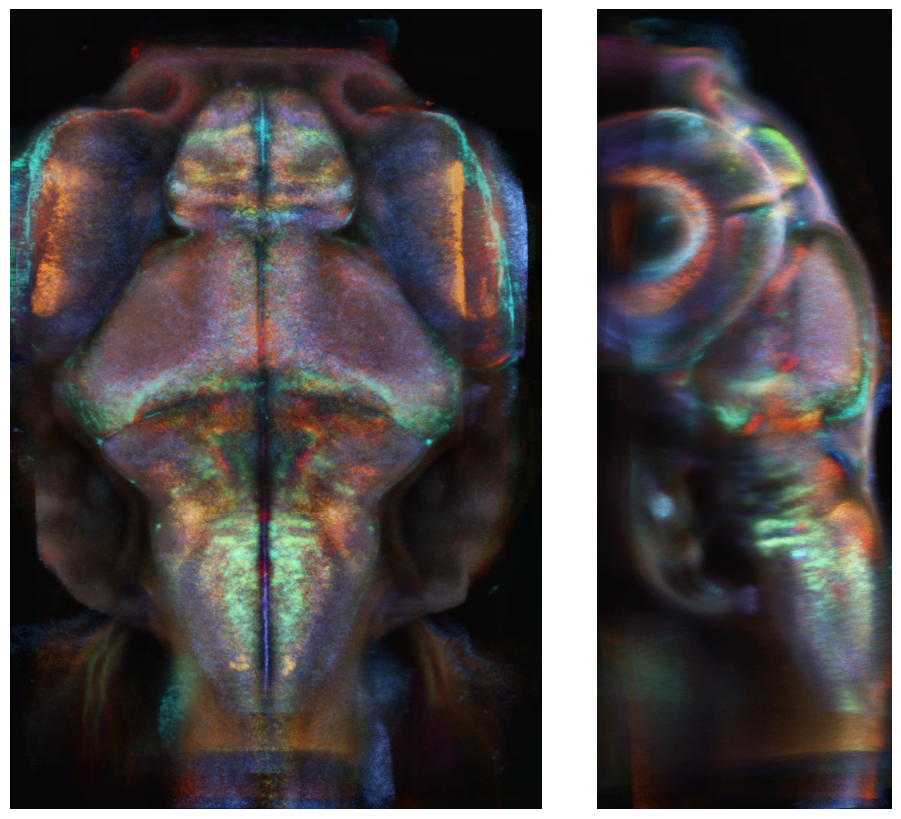

In [196]:
im1 = merge_with_pixelwise_color_contrast(projections_top, colors)
im2 = merge_with_pixelwise_color_contrast(projections_side, colors)

for i in range(3):
    im1[:, :, i] = gaussian_filter(im1[:, :, i], 0.5)
    im2[:, :, i] = gaussian_filter(im2[:, :, i], 0.5)

fig, ax = plt.subplots(1, 2, figsize=(10, 8))
ax[0].imshow(im1, aspect='auto')
ax[0].axis('off')

ax[1].imshow(np.rot90(im2, k=3))
ax[1].axis('off')

plt.tight_layout(pad=0)

np.save('Results/figure7_optimal_genes_projection_top.npy', im1)
np.save('Results/figure7_optimal_genes_projection_side.npy', im2)
np.save('Results/figure7_optimal_genes_colors.npy', colors)

# Studying gene descriptions

In [62]:
from collections import Counter
from scipy import stats

def read_lines_from_file(file_path):
    try:
        with open(file_path, 'r') as file:
            lines = file.readlines()
            return lines
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        return []
    
def read_gene_descriptions(file_path):
    lines = read_lines_from_file(file_path)
    lines2 = []
    for line in lines:
        if line != '\n':
            lines2.append(line.strip('\n').strip(' '))
    ids = np.linspace(0, 580, 290, endpoint=False).astype('int')
    descriptions = {}
    for i in ids:
        descriptions[lines2[i]] = lines2[i + 1]
    return descriptions

def get_word_counts(gene_names, descriptions):
    
    all_words = []
    for name in gene_names:
        words = list(np.unique(descriptions[name].lower().split(' ')))
        all_words += words

    # Cleaning punctuation leftovers
    for i in range(len(all_words)):
        all_words[i] = all_words[i].strip('.')
        all_words[i] = all_words[i].strip('(')
        all_words[i] = all_words[i].strip(')')
        all_words[i] = all_words[i].strip(';')

    word_counts = Counter(all_words)
    sorted_word_counts = word_counts.most_common()
    
    return sorted_word_counts

def get_keyword_counts(word_counts, keywords):
    
    counts, words = [], []

    for wc in word_counts:
        words.append(wc[0])
    words = np.array(words) 

    for word in keywords:
        if np.any(np.where(words == word)):
            i = np.where(words == word)[0][0]
            counts.append(word_counts[i][1])
        else:
            counts.append(0)
    
    return np.array(counts)

def compute_zscores(true_counts, random_counts):
    z_scores = (true_counts - np.mean(random_counts, axis=0)) / np.std(random_counts, axis=0, ddof=1)
    p_values = 2 * (1 - stats.norm.cdf(np.abs(z_scores)))
    return z_scores, p_values

In [63]:
descriptions = read_gene_descriptions('Genes/gene_descriptions.txt')

# Hand-picked words from all the words in the descriptions
keywords = ['binding', 'nucleus', 'dna-binding', 'rna', 'dna', 'neural', 'receptor', 'cell', 'polymerase', 'signaling', 'development', 'pathway', 'activity', 'regulation', 'receptor', 'cis-regulatory', 'complex', 'membrane', 'extracellular', 'differentiation', 'digestive', 'eye', 'heart', 'liver', 'visual', 'neuropeptide', 'chromatin', 'vesicle', 'neuron', 'nuclear', 'synaptic', 'synapse', 'cytoplasm', 'retina', 'behavior', 'cholinergic', 'transmission', 'optic', 'ion', 'acetylcholine', 'postsynaptic', 'channel', 'projection', 'transmembrane', 'circadian', 'calcium', 'spine', 'terminal', 'potentiation', 'presynaptic', 'cytosol', 'cytosolic', 'bouton', 'dendrite', 'muscarinic', 'modulator', 'inhibitor', 'neurotransmitter']
keywords = list(np.sort(keywords))

In [671]:
transcription_factors = []
for i, gene in enumerate(descriptions.keys()):
    if 'transcription factor' in descriptions[gene]:
        transcription_factors.append(1)
    else:
        transcription_factors.append(0)

In [672]:
np.save('Results/figure7_transcription_factors_ids.npy', transcription_factors)

#### Gene descriptions of maximally-correlated gene set

In [41]:
most_correlated_genes = np.unique(maximally_correlated_set)
most_correlated_names = np.array(names)[np.sort(most_correlated_genes)]

In [42]:
for name in most_correlated_names:
    print(name)

aldoab
crema
ctnnb2
galn
ghrh
isl2b
mef2cb
npy2rl
npy4r
opn7b
pomca
sox1b
stc2a
tbx2b
tsnare1


In [43]:
word_counts_maximal = get_word_counts(most_correlated_names, descriptions)
maximal_counts = get_keyword_counts(word_counts_maximal, keywords)

In [44]:
random_counts = []

for _ in tqdm(range(10000), file=sys.stdout):
    random_ids = select_M_from_N(Mgenes, Ngenes).astype('bool')
    random_names = list(np.array(names)[random_ids])
    word_counts_random = get_word_counts(random_names, descriptions)
    random_counts.append(get_keyword_counts(word_counts_random, keywords))
    
random_counts = np.stack(random_counts, axis=0)

100%|████████████████████████████████████| 10000/10000 [00:13<00:00, 734.15it/s]


In [45]:
zscores, pvalues = compute_zscores(maximal_counts, random_counts)

In [55]:
significant_most_correlated = list(np.array(keywords)[np.where(pvalues < 0.05)[0]])
significant_most_correlated

['binding', 'heart', 'modulator', 'neuropeptide', 'signaling']

In [54]:
zscores_most_correlated = zscores[np.where(pvalues < 0.05)[0]]
zscores_most_correlated

array([-1.65515117,  2.70941362,  4.32240337,  2.38322011,  1.7113915 ])

#### Gene descriptions of maximally selected set

In [48]:
most_selected_names = np.array(names)[np.sort(most_selected_genes)]
most_selected_names

array(['aldoab', 'crema', 'ctnnb2', 'galn', 'gfra1a', 'isl2b', 'mef2cb',
       'npy2rl', 'npy4r', 'opn7b', 'pomca', 'pth2r', 'sox1b', 'stc2a',
       'tbx2b'], dtype='<U16')

In [49]:
word_counts_selected = get_word_counts(most_selected_names, descriptions)
selected_counts = get_keyword_counts(word_counts_selected, keywords)

In [50]:
random_counts = []

for _ in tqdm(range(10000), file=sys.stdout):
    random_ids = select_M_from_N(Mgenes, Ngenes).astype('bool')
    random_names = list(np.array(names)[random_ids])
    word_counts_random = get_word_counts(random_names, descriptions)
    random_counts.append(get_keyword_counts(word_counts_random, keywords))
    
random_counts = np.stack(random_counts, axis=0)

100%|████████████████████████████████████| 10000/10000 [00:13<00:00, 732.82it/s]


In [51]:
zscores, pvalues = compute_zscores(selected_counts, random_counts)

In [52]:
significant_most_selected = list(np.array(keywords)[np.where(pvalues < 0.05)[0]])
significant_most_selected

['heart', 'modulator', 'neuropeptide']

In [53]:
zscores_most_selected = zscores[np.where(pvalues < 0.05)[0]]
zscores_most_selected

array([2.70941362, 4.32240337, 2.38322011])